# Convolutional Neural Network

In [1]:
# Import librarys
# normal 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# open file
from IPython.display import Image
import os
import PIL

# model CNN (Deep learning network)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense,\
GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Create function plot loss function and accuracy score graph
def plot_graph(model_values):
    ''' 
    Input : Model_values of keras.callbacks.History
    Return : Graph of Loss function and accuracy score between training dataset and vaildation dataset
    '''
    # Subplots
    fig, ax = plt.subplots(1, 2, figsize=(14,5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(model_values.history['loss'], label='Training Loss');
    plt.plot(model_values.history['val_loss'], label='Testing Loss');
    plt.legend(fontsize=12, loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss');
    
    # Plot MSE
    plt.subplot(1, 2, 2)
    
    plt.plot(model_values.history['accuracy'], label='Training Accuracy')
    plt.plot(model_values.history['val_accuracy'], label='Validation Accuracy')
    
    plt.legend(fontsize=12, loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy');

## 00-Check GPU/CPU

In [3]:
# https://www.tensorflow.org/guide/keras/sequential_model
# Due to we use Keras Sequential API, 
# We want to check GPU first before training our model for 
# impore efficiency and reduce time. 
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8971405250196765324
xla_global_id: -1
]


## 01-Open datasets

In [4]:
# Define the paths
original_dataset_path = r'C:\Users\HP\Desktop\Data\poultry_disease_detection_third_iteration\poultry_data'
train_path = r"C:\Users\HP\Desktop\Data\poultry_disease_detection_third_iteration\Train"
validation_path = r"C:\Users\HP\Desktop\Data\poultry_disease_detection_third_iteration\Validate"
test_path = r"C:\Users\HP\Desktop\Data\poultry_disease_detection_third_iteration\Test"

## 02-Preprocessing image dataset

In [5]:
# Set parameters for image size and batch size
img_height = 128
img_width = 128
batch_size = 50

In [6]:
# Rescale pixel values to reduce image size before using in the model
data_gen_train = ImageDataGenerator(rescale=1/255.)
data_gen_valid = ImageDataGenerator(rescale=1/255.)
data_gen_test = ImageDataGenerator(rescale=1/255.)

In [7]:
# Create training dataset
train_dataset = data_gen_train.flow_from_directory(train_path,
                                                   class_mode="categorical",
                                                   target_size=(img_height, img_width),
                                                   batch_size=batch_size)

# Create validation dataset
valid_dataset = data_gen_valid.flow_from_directory(validation_path,
                                                   class_mode="categorical",
                                                   target_size=(img_height, img_width),
                                                   batch_size=batch_size)

# Create testing dataset
test_dataset = data_gen_test.flow_from_directory(test_path,
                                                 class_mode="categorical",
                                                 target_size=(img_height, img_width),
                                                 batch_size=batch_size)


Found 6951 images belonging to 4 classes.
Found 870 images belonging to 4 classes.
Found 871 images belonging to 4 classes.


In [8]:
# Display class distribution in the training dataset
print("Classes in the training dataset:")
print(pd.Series(train_dataset.classes).value_counts(normalize=True).mul(100))
print("Class indices:", train_dataset.class_indices)

Classes in the training dataset:
3    26.183283
2    25.953100
0    24.197957
1    23.665660
Name: proportion, dtype: float64
Class indices: {'Coccidiosis': 0, 'Healthy poultry': 1, 'Newcastle diseases': 2, 'Salmonella': 3}


In [9]:
# Display class distribution in the validation dataset
print("\nClasses in the validation dataset:")
print(pd.Series(valid_dataset.classes).value_counts())


Classes in the validation dataset:
3    228
2    226
0    210
1    206
Name: count, dtype: int64


In [10]:
# Display class distribution in the testing dataset
print("\nClasses in the testing dataset:")
print(pd.Series(test_dataset.classes).value_counts())


Classes in the testing dataset:
3    228
2    226
0    211
1    206
Name: count, dtype: int64


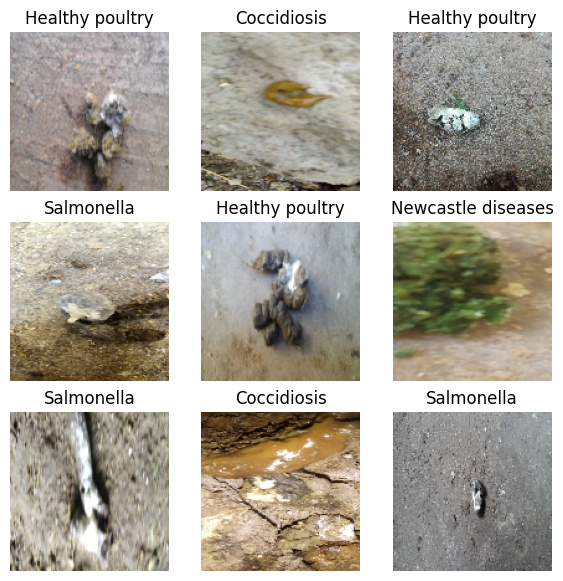

In [14]:
# show some image sample in training dataset
images, labels_class = next(train_dataset)
classes = train_dataset.class_indices
plt.figure(figsize=(7, 7))
for i in range(9):
    label = [j for j in classes if classes[j] == np.argmax(labels_class[i])][0]
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i]*255.).astype("uint8"))
    plt.title(label)
    plt.axis("off")

In [12]:
# Recheck after rescale
print(images[0].max())
print(images[0].min())

1.0
0.0


## 03-CNN model training

In [15]:
# Training model
# Compile the model
model = Sequential()

# Input layer
model.add(Conv2D(16,(3,3), activation='relu',
                 kernel_initializer='he_uniform', 
                 padding='same', input_shape=(128,128,3))) # filter image by dot product in matrix to find the object in picture
# Hidden layers
model.add(MaxPooling2D(pool_size=(2,2))) # reduce stucture of image even if object slightly move but the result is same  
model.add(Conv2D(32,(3,3), activation='relu',
                 kernel_initializer='he_uniform', 
                 padding='same')) 
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten()) # convert all the resultant 2-Dimensional arrays into a single long continuous linear vector
model.add(Dense(64, activation='relu',
                kernel_initializer='he_uniform'))

# avoid overfitting!
model.add(Dropout(0.5))

# Output layer
model.add(Dense(4, activation='softmax'))

# Compile the model         
model.compile(loss="categorical_crossentropy", 
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [16]:
# we have 2,102,564 nodes for training
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 64)                2

In [17]:
# Save checkpoints during training
checkpoint_path = r"C:\Users\HP\Desktop\Data\poultry_disease_detection_third_iteration\models\cnn\cnn_model_cp\cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [18]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [19]:
# training model 
# make sure you truely save checkpoint_path
history = model.fit(train_dataset,
                              epochs=25,
                              validation_data=valid_dataset,
                              callbacks=[cp_callback])

Epoch 1/25


140/140 [==============================] - ETA: 0s - loss: 1.4396 - accuracy: 0.3617
Epoch 1: saving model to C:\Users\HP\Desktop\Data\Poultry_disease_detection_final\Models\cnn\cnn_model_cp\cp.ckpt
140/140 [==============================] - 546s 4s/step - loss: 1.4396 - accuracy: 0.3617 - val_loss: 1.1835 - val_accuracy: 0.3862
Epoch 2/25
140/140 [==============================] - ETA: 0s - loss: 1.2060 - accuracy: 0.3971
Epoch 2: saving model to C:\Users\HP\Desktop\Data\Poultry_disease_detection_final\Models\cnn\cnn_model_cp\cp.ckpt
140/140 [==============================] - 470s 3s/step - loss: 1.2060 - accuracy: 0.3971 - val_loss: 1.0967 - val_accuracy: 0.4954
Epoch 3/25
140/140 [==============================] - ETA: 0s - loss: 1.0883 - accuracy: 0.4886
Epoch 3: saving model to C:\Users\HP\Desktop\Data\Poultry_disease_detection_final\Models\cnn\cnn_model_cp\cp.ckpt
140/140 [==============================] - 474s 3s/step - loss: 1.0883 - accuracy: 0.4886 - val_loss: 0.

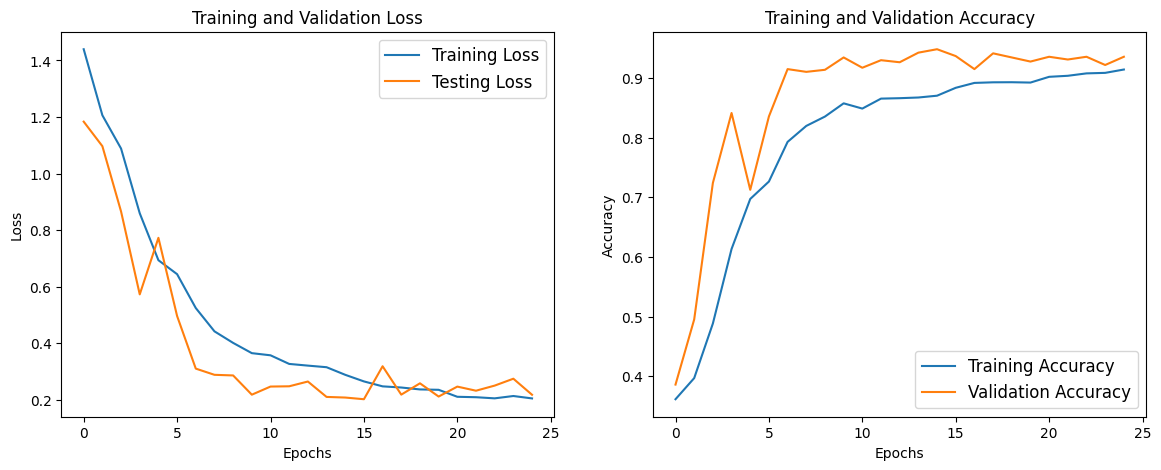

In [20]:
# plot graph 
plot_graph(history)

In [21]:
# save model
model.save(r"C:\Users\HP\Desktop\Data\poultry_disease_detection_third_iteration\models\cnn\cnn_model.h5")

C:\Users\HP\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
# create dataframe to save in .csv file
hist_df = pd.DataFrame(history.history) 
hist_df.head()

# Save history to CSV file
hist_csv_file = r"C:\Users\HP\Desktop\Data\poultry_disease_detection_third_iteration\models\cnn\history_cnn_model16.csv"
hist_df.to_csv(hist_csv_file, index=False)  # Set index=False to exclude the index column

## Convert to TfLite

In [2]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model(r"C:\Users\HP\Desktop\Data\poultry_disease_detection_third_iteration\models\cnn\cnn_model.h5")

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open(r'C:\Users\HP\Desktop\Data\poultry_disease_detection_third_iteration\models\cnn\cnn_model.tflite', 'wb') as f:
    f.write(tflite_model)



INFO:tensorflow:Assets written to: C:\Users\HP\AppData\Local\Temp\tmpo3tb66tz\assets


INFO:tensorflow:Assets written to: C:\Users\HP\AppData\Local\Temp\tmpo3tb66tz\assets
